In [4]:
# Define a helper to read all sheets from the Excel file and setting up a main DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def read_all_sheets_from_excel(path):
    xls = pd.ExcelFile(path)
    dfs = {}
    for sheet in xls.sheet_names:
        df = pd.read_excel(path, sheet_name=sheet)
        # Standardize column names to lower-case and strip spaces
        df.columns = [str(c).strip() for c in df.columns]
        dfs[sheet] = df
    return dfs

# Use the local file (already available in this session)
filepath = '/content/1730285881-Airbnb_Open_Data.xlsx'
dataframes = read_all_sheets_from_excel('/content/1730285881-Airbnb_Open_Data.xlsx')

# Pick a primary sheet. If there’s a sheet named 'Listings' or similar, use that; else use the first.
preferred_names = ['Listings', 'Airbnb', 'Sheet1', 'data', 'Main', 'listings']
chosen_key = None
for name in dataframes.keys():
    if name in preferred_names:
        chosen_key = name
        break
if chosen_key is None:
    chosen_key = list(dataframes.keys())[0]

df_main = dataframes[chosen_key].copy()

print(list(dataframes.keys()))
print(df_main.head())
print(df_main.describe(include='all'))

['in']
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee  minimum nights  \
0  40.64749 -73.97237  U

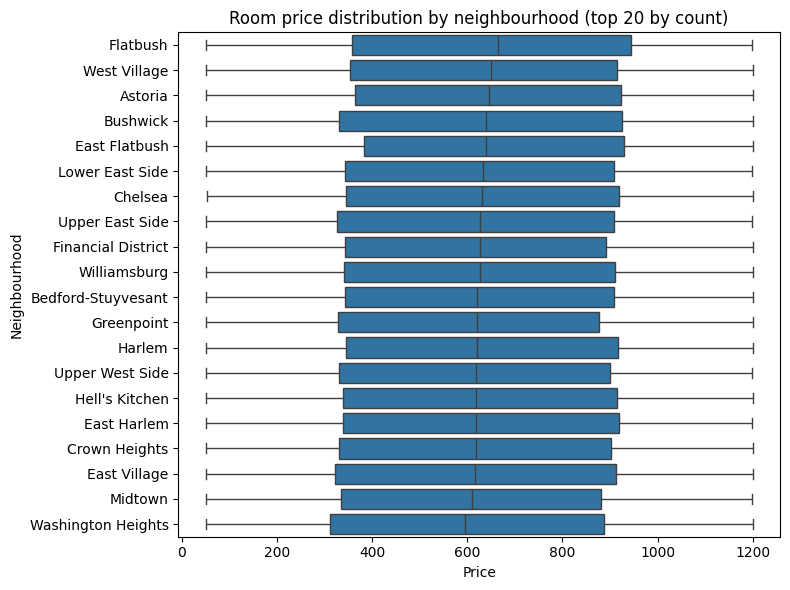

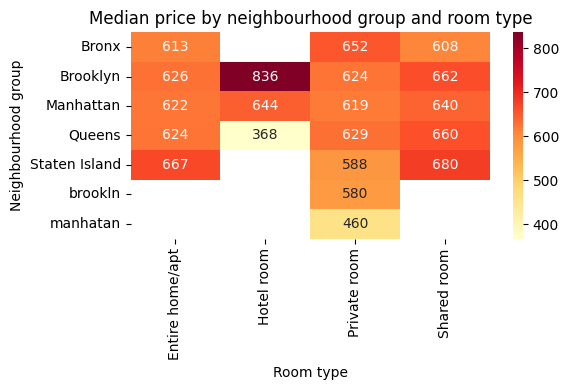

Plotted price distributions by neighbourhood and a median price heatmap


In [14]:
# Which neighbourhoods or groups have the highest average listing prices?
# We'll show: top 20 neighbourhoods by count with boxplots; and a heatmap of median prices by neighbourhood group vs room type
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Ensure df_main exists and price numeric
if 'df_main' in globals():
    if 'price' in df_main.columns:
        df_main['price'] = pd.to_numeric(df_main['price'], errors='coerce')

    # Pick neighbourhoods with enough listings for stable distributions
    if 'neighbourhood' in df_main.columns and 'price' in df_main.columns:
        counts = df_main['neighbourhood'].value_counts()
        top_neighs = counts.head(20).index.tolist()
        subset = df_main[df_main['neighbourhood'].isin(top_neighs)][['neighbourhood','price','room type']].copy()

        # Boxplot of prices by neighbourhood (top 20 by count)
        ordered = subset.groupby('neighbourhood')['price'].median().sort_values(ascending=False).index
        plt.figure(figsize=(8,6))
        sns.boxplot(data=subset, y='neighbourhood', x='price', order=ordered, showfliers=False)
        plt.title('Room price distribution by neighbourhood (top 20 by count)')
        plt.xlabel('Price')
        plt.ylabel('Neighbourhood')
        plt.tight_layout()
        plt.show()

    # Heatmap: median price by neighbourhood group and room type
    if 'neighbourhood group' in df_main.columns and 'room type' in df_main.columns and 'price' in df_main.columns:
        pivot_med = df_main.pivot_table(index='neighbourhood group', columns='room type', values='price', aggfunc='median')
        plt.figure(figsize=(6,4))
        sns.heatmap(pivot_med, annot=True, fmt='.0f', cmap='YlOrRd')
        plt.title('Median price by neighbourhood group and room type')
        plt.xlabel('Room type')
        plt.ylabel('Neighbourhood group')
        plt.tight_layout()
        plt.show()

print('Plotted price distributions by neighbourhood and a median price heatmap')

             listings_count  avg_price   host_name
host id                                           
29626370251               2      986.0         Ben
93151875101               2     1066.0     Gabriel
27696810738               2     1072.0       Jimmy
37678424985               2      806.0     Juliana
49747569066               2      125.0      Miriam
92780269224               2       88.0     Lindsay
538762830                 2      609.0  Alessandra
27692673803               2      602.0      Irisha
71002819580               2      160.0        Ryan
98342871281               2     1109.0       Karen
59749079462               2      427.0      Alissa
91966235764               2      626.0     Adriana
71983028797               2      679.0      Sonder
68170633372               2     1032.0     Rebecca
51604923776               2      625.0         Ace
32202051101               2     1200.0    Chun Kit
1570276266                2      979.0      Ashley
51386896065               2    

/tmp/ipython-input-3011573140.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='listings_count', y=y_labels, data=plot_df, palette='Blues_r')


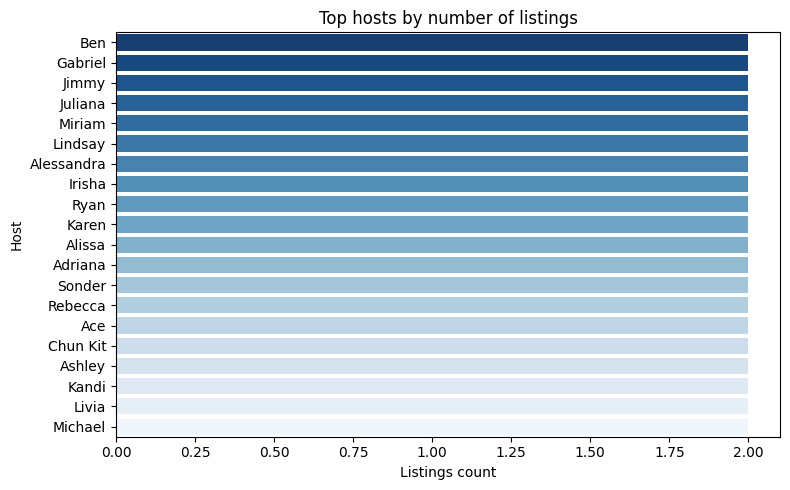

/tmp/ipython-input-3011573140.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_price', y=y_labels, data=plot_df, palette='Oranges')


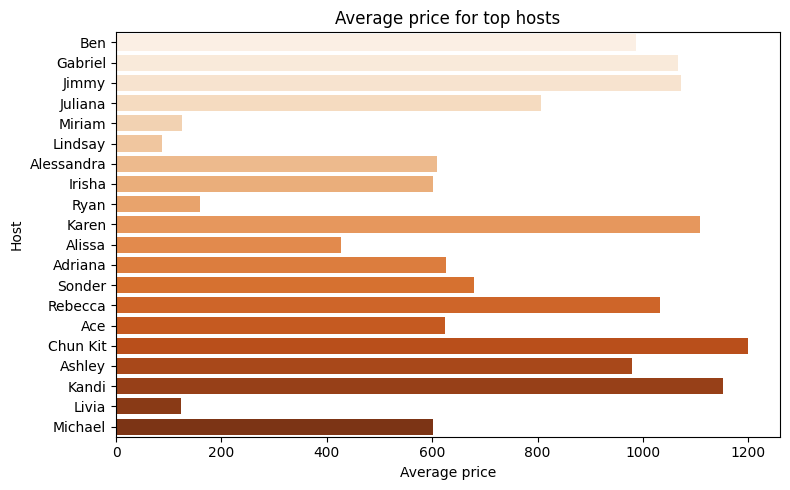

Computed top hosts by listings and their average prices


In [15]:
# Find hosts with the most listings and compute their average prices. Show top 20 by listing count and a bar plot.
# Assumes df_main is loaded with columns: host_id or host id, host name, price.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Normalize likely column names
if 'df_main' in globals():
    cols = {c.lower().strip(): c for c in df_main.columns}
    # Identify host id/name columns (handling variants)
    host_id_col = None
    for cand in ['host id','host_id','hostid']:
        if cand in cols:
            host_id_col = cols[cand]
            break
    host_name_col = None
    for cand in ['host name','host_name','hostname']:
        if cand in cols:
            host_name_col = cols[cand]
            break
    # Ensure price numeric
    if 'price' in df_main.columns:
        df_main['price'] = pd.to_numeric(df_main['price'], errors='coerce')

    # Group and compute counts and mean price
    if host_id_col is not None and 'price' in df_main.columns:
        grp = df_main.groupby(host_id_col).agg(listings_count=(host_id_col,'size'), avg_price=('price','mean'))
        # Attach a representative host name if available
        if host_name_col is not None:
            name_map = df_main[[host_id_col, host_name_col]].dropna().drop_duplicates().set_index(host_id_col)[host_name_col]
            grp = grp.join(name_map, how='left')
            grp = grp.rename(columns={host_name_col:'host_name'})
        top_hosts = grp.sort_values('listings_count', ascending=False).head(20)
        print(top_hosts.head(20))

        # Plot listings count (primary), color by avg price
        plt.figure(figsize=(8,5))
        plot_df = top_hosts.reset_index()
        y_labels = plot_df['host_name'] if 'host_name' in plot_df.columns else plot_df[host_id_col].astype(str)
        sns.barplot(x='listings_count', y=y_labels, data=plot_df, palette='Blues_r')
        plt.title('Top hosts by number of listings')
        plt.xlabel('Listings count')
        plt.ylabel('Host')
        plt.tight_layout()
        plt.show()

        # Plot their average prices
        plt.figure(figsize=(8,5))
        sns.barplot(x='avg_price', y=y_labels, data=plot_df, palette='Oranges')
        plt.title('Average price for top hosts')
        plt.xlabel('Average price')
        plt.ylabel('Host')
        plt.tight_layout()
        plt.show()

print('Computed top hosts by listings and their average prices')

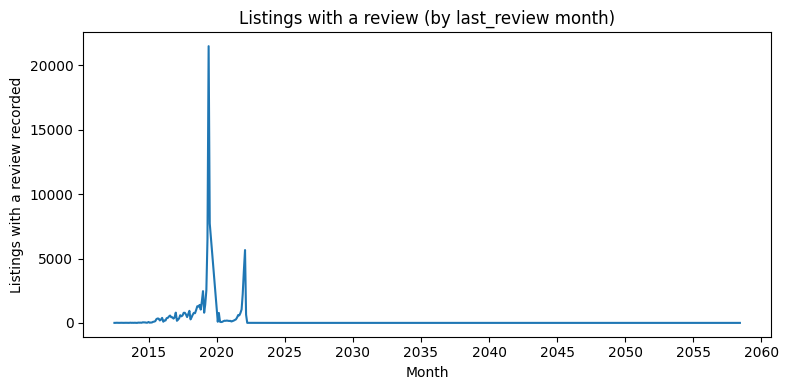

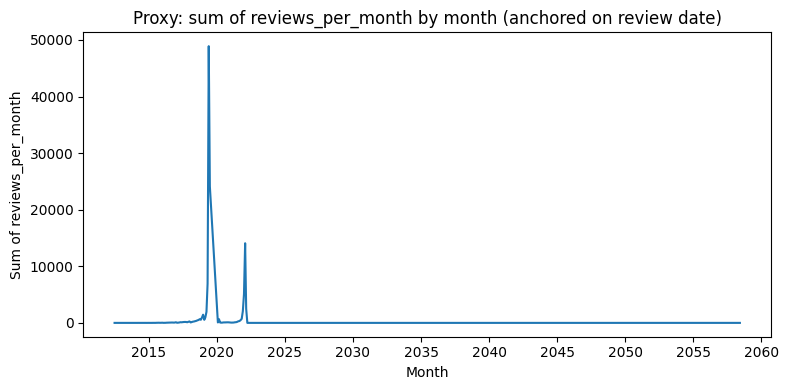

Plotted review activity trends over time: 2 figure(s)


In [7]:
# Analyze trend of review activity over time.
# We will look for columns like 'last_review', 'reviews_per_month', or a reviews dataset with 'date'.
# We'll produce: monthly total reviews added proxy using reviews_per_month * availability indicator, and counts of last_review dates.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Helper to parse dates if present

def to_datetime_safe(s):
    return pd.to_datetime(s, errors='coerce')

plots_made = 0

if 'df_main' in globals():
    cols_lower = {c.lower().strip(): c for c in df_main.columns}

    # Option 1: Use last_review to count active reviews by month
    if 'last review' in cols_lower:
        lr_col = cols_lower['last review']
        tmp = df_main[[lr_col]].copy()
        tmp[lr_col] = to_datetime_safe(tmp[lr_col])
        tmp = tmp.dropna()
        if not tmp.empty:
            tmp['year_month'] = tmp[lr_col].dt.to_period('M').dt.to_timestamp()
            monthly_counts = tmp.groupby('year_month').size().reset_index(name='listings_with_review')
            plt.figure(figsize=(8,4))
            sns.lineplot(data=monthly_counts.sort_values('year_month'), x='year_month', y='listings_with_review')
            plt.title('Listings with a review (by last_review month)')
            plt.xlabel('Month')
            plt.ylabel('Listings with a review recorded')
            plt.tight_layout()
            plt.show()
            plots_made += 1

    # Option 2: Use reviews_per_month aggregated over listings as a proxy for total monthly reviews
    rpm_col = None
    for cand in ['reviews_per_month','review_rate_number','reviews per month','review rate number']:
        if cand in cols_lower:
            rpm_col = cols_lower[cand]
            break
    if rpm_col is not None:
        df_main[rpm_col] = pd.to_numeric(df_main[rpm_col], errors='coerce')
        # If we have a date anchor like first_review or last_review, use last_review month; otherwise just show distribution of rpm over time not possible
        date_anchor = None
        for cand in ['last review','first review']:
            if cand in cols_lower:
                date_anchor = cols_lower[cand]
                break
        if date_anchor is not None:
            tmp2 = df_main[[rpm_col, date_anchor]].copy()
            tmp2[date_anchor] = to_datetime_safe(tmp2[date_anchor])
            tmp2 = tmp2.dropna(subset=[date_anchor])
            if not tmp2.empty:
                tmp2['year_month'] = tmp2[date_anchor].dt.to_period('M').dt.to_timestamp()
                monthly_rpm = tmp2.groupby('year_month')[rpm_col].sum().reset_index()
                plt.figure(figsize=(8,4))
                sns.lineplot(data=monthly_rpm.sort_values('year_month'), x='year_month', y=rpm_col)
                plt.title('Proxy: sum of reviews_per_month by month (anchored on review date)')
                plt.xlabel('Month')
                plt.ylabel('Sum of reviews_per_month')
                plt.tight_layout()
                plt.show()
                plots_made += 1

print('Plotted review activity trends over time: ' + str(plots_made) + ' figure(s)')

neighbourhood group
Queens           630.207647
Bronx            627.766359
Brooklyn         626.562193
Staten Island    624.490546
Manhattan        622.440227
brookln          580.000000
manhatan         460.000000
Name: price, dtype: float64


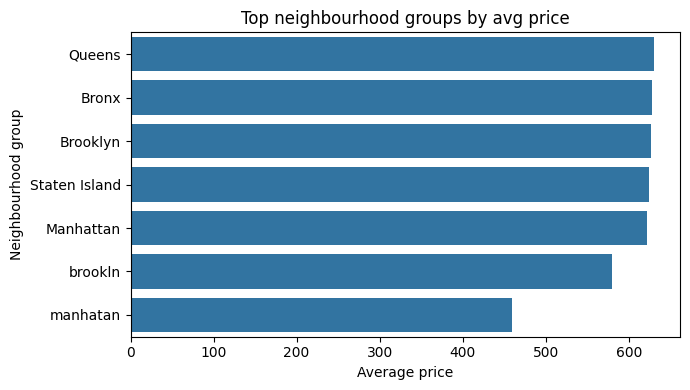

neighbourhood
New Dorp                  1045.000000
Chelsea, Staten Island    1042.000000
Fort Wadsworth            1024.000000
Little Neck                817.750000
Jamaica Hills              812.904762
Arden Heights              804.888889
Midland Beach              796.176471
Shore Acres                792.260870
Mill Basin                 775.142857
Riverdale                  768.736842
Name: price, dtype: float64


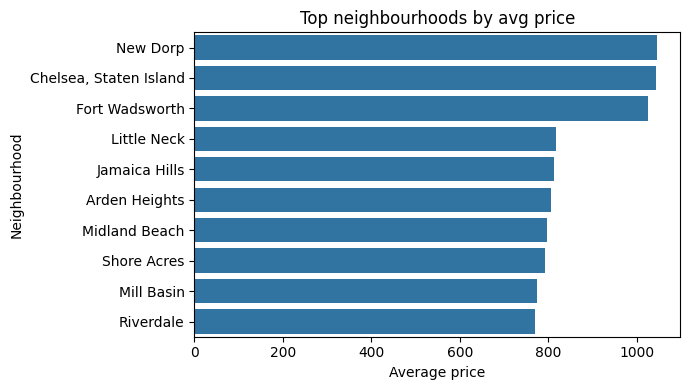

Computed and visualized top average prices by group and neighbourhood


In [8]:
# Computing and visualizing highest average prices by neighbourhood group and neighbourhood.
# Show top 10 for each and a bar chart for quick comparison.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Using df_main from earlier
results_group = None
results_neigh = None

if 'df_main' in globals():
    # Coerce price
    if 'price' in df_main.columns:
        df_main['price'] = pd.to_numeric(df_main['price'], errors='coerce')

    # By neighbourhood group
    if 'neighbourhood group' in df_main.columns and 'price' in df_main.columns:
        results_group = df_main.groupby('neighbourhood group')['price'].mean().sort_values(ascending=False).head(10)
        print(results_group)
        plt.figure(figsize=(7,4))
        sns.barplot(x=results_group.values, y=results_group.index, orient='h')
        plt.title('Top neighbourhood groups by avg price')
        plt.xlabel('Average price')
        plt.ylabel('Neighbourhood group')
        plt.tight_layout()
        plt.show()

    # By neighbourhood
    if 'neighbourhood' in df_main.columns and 'price' in df_main.columns:
        results_neigh = df_main.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10)
        print(results_neigh)
        plt.figure(figsize=(7,4))
        sns.barplot(x=results_neigh.values, y=results_neigh.index, orient='h')
        plt.title('Top neighbourhoods by avg price')
        plt.xlabel('Average price')
        plt.ylabel('Neighbourhood')
        plt.tight_layout()
        plt.show()

print('Computed and visualized top average prices by group and neighbourhood')

   minimum nights  number of reviews  reviews per month  availability 365
0            10.0                9.0               0.21             286.0
1            30.0               45.0               0.38             228.0
2             3.0                0.0                NaN             352.0
3            30.0              270.0               4.64             322.0
4            10.0                9.0               0.10             289.0
                   minimum nights  number of reviews  reviews per month  \
minimum nights           1.000000          -0.049997          -0.096141   
number of reviews       -0.049997           1.000000           0.590939   
reviews per month       -0.096141           0.590939           1.000000   
availability 365         0.063541           0.099368           0.077193   

                   availability 365  
minimum nights             0.063541  
number of reviews          0.099368  
reviews per month          0.077193  
availability 365           1

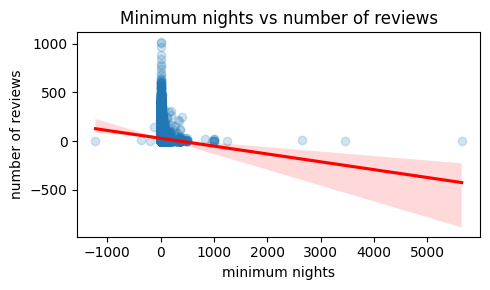

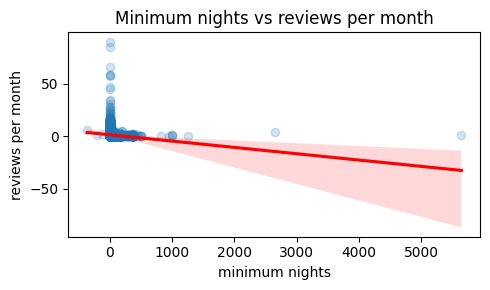

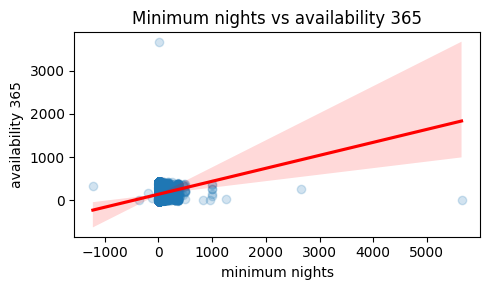

Computed correlations and plotted 3 relationships


In [10]:
# Analyze whether minimum nights relates to reviews (count and per-month) and availability.
# We will compute correlations and visualize simple relationships.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load once
if 'df_main' not in globals():
    df_main = pd.read_excel('1730285881-Airbnb_Open_Data.xlsx')

cols = {c.lower().strip(): c for c in df_main.columns}
min_nights_col = cols.get('minimum nights')
num_reviews_col = cols.get('number of reviews')
rpm_col = cols.get('reviews per month')
avail_col = cols.get('availability 365')

work = df_main[[min_nights_col, num_reviews_col, rpm_col, avail_col]].copy()

for c in [min_nights_col, num_reviews_col, rpm_col, avail_col]:
    work[c] = pd.to_numeric(work[c], errors='coerce')

print(work.head())

# Correlations
corr = work.corr(numeric_only=True)
print(corr)

# Scatter plots with trendlines
plt.figure(figsize=(5,3))
sns.regplot(data=work, x=min_nights_col, y=num_reviews_col, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Minimum nights vs number of reviews')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
sns.regplot(data=work, x=min_nights_col, y=rpm_col, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Minimum nights vs reviews per month')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
sns.regplot(data=work, x=min_nights_col, y=avail_col, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Minimum nights vs availability 365')
plt.tight_layout()
plt.show()

print('Computed correlations and plotted 3 relationships')

0.9999908755543448


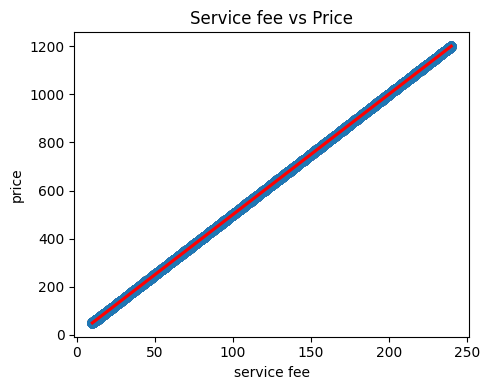

Computed correlation and plotted relationship


In [16]:
# Computing the correlation between service fee and price, and show a quick scatter with trendline.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if 'df_main' not in globals():
    df_main = pd.read_excel('1730285881-Airbnb_Open_Data.xlsx')

cols = {c.lower().strip(): c for c in df_main.columns}
price_col = cols.get('price')
fee_col = cols.get('service fee')

subset = df_main[[price_col, fee_col]].copy()
subset[price_col] = pd.to_numeric(subset[price_col], errors='coerce')
subset[fee_col] = pd.to_numeric(subset[fee_col], errors='coerce')

corr_val = subset[[price_col, fee_col]].corr(numeric_only=True).iloc[0,1]
print(corr_val)

plt.figure(figsize=(5,4))
sns.regplot(data=subset, x=fee_col, y=price_col, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Service fee vs Price')
plt.tight_layout()
plt.show()

print('Computed correlation and plotted relationship')